## INTRO   

### 주제
- 앱 이용자 별 향후 이용 건수 예측
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
  
### 모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측
  
### Data 정의
- Input: Tabular 데이터(2020.01.01 ~ 2020.12-31)
- Output: Regression (향후 이용 건수 예측)  

### Task 정의
- Regression, 유저 별 한 달 후 이용 건수 예측
  
### Metric 정의
- MSE, MAE
  
### 데이터 수집
- 유저 가입 정보: id(USER_ID) , 가입일(JOIN_DATE) 
- 소비 행동 정보: 상품id(GOODS_TYPE), 점포 주소(STORE_ID), 결제일(DATE), 결제건수(COUNT) 
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터  

## Data Load   
### Library

In [2]:
import pandas as pd 
import numpy as np 
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False  

# API 크롤링 라이브러리 
from urllib.parse import urlencode, quote_plus
from urllib.request import Request, urlopen
from xml.etree import ElementTree 
from urllib.error import HTTPError, URLError
import requests

from statsmodels.tsa.seasonal import seasonal_decompose 

#model 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error


pd.options.display.max_rows=1000

### Load

In [3]:
data = pd.read_csv('../project_modu/data_modu.csv')
data.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
data.weekofday=data.weekofday.astype(int)

In [4]:
print(f'데이터 사이즈 : {data.shape}')

데이터 사이즈 : (879271, 11)


In [ ]:
# msno.matrix(data)  #missing values (X) 

In [ ]:
data.info()

In [5]:
data['DATE']=pd.to_datetime(data['DATE'])
data['JOIN_DATE']=pd.to_datetime(data['JOIN_DATE'])

# 결제날짜 : 연도, 월, 일 컬럼 생성 
# data['Year'] = data.DATE.dt.year
# data['Month'] = data.DATE.dt.month
# data['Day'] = data.DATE.dt.day

# 가입날짜 : 연도, 월, 일 컬럼  -> 필요할까? 
# data['JOIN_Year'] = data.JOIN_DATE.dt.year
# data['JOIN_Month'] = data.JOIN_DATE.dt.month
# data['JOIN_Day'] = data.JOIN_DATE.dt.day

# 결제 요일 
# KST = pytz.timezone('Asia/Seoul')
# for idx, (m, d) in enumerate(zip(data.Month, data.Day)):
#     mydate = datetime(2020, m,d)
#     mydate_kst = KST.localize(mydate)
#     data.at[idx, 'weekofday'] = mydate_kst.weekday()

In [6]:
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

In [ ]:
display(train.head(3))
display(test.head(3))

### 날씨 - API 크롤링 

In [10]:
# 공유된 데이터 확인
# weather = pd.read_csv('../project_modu/서울시_기상데이터.csv', encoding='CP949')

# 일자별 날씨로 크롤링 하기로 함 
# ------------------------ 크롤링
# url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

# params = '?'+ 'ServiceKey=' + service_key + '&' + \
#     urlencode({ quote_plus('ServiceKey') : '서비스키', 
#                 quote_plus('dataType') : 'XML',
#                 quote_plus('pageNo') : '1', 
#                 quote_plus('numOfRows') : '366', 
#                 quote_plus('dataCd') : 'ASOS',
#                 quote_plus('dateCd') : 'DAY', 
#                 quote_plus('startDt') : '20200101',  
#                 quote_plus('endDt') : '20210101', 
#                 quote_plus('stnIds') : '108' })

               
# df = pd.DataFrame()
    
    
# request = Request(url + params)
# request.get_method = lambda: 'GET'

# try:
#     response_body = urlopen(request).read()
# except HTTPError as e:
#     print(e)
# except URLError as e:
#     print('The server coult not be found')
# else:
#     print('성공')


# root= ElementTree.fromstring(response_body)

# for item in root.iter('item'):
#     item_dict = {}
# #     지점, 일시, 기온, 강수량, 풍속, 습도, 일조시간, 적설량, 지면온도, 지중온도
#     item_dict['일시'] = item.find('tm').text
#     item_dict['지점'] = item.find('stnId').text
#     item_dict['평균기온'] = item.find('avgTa').text
#     item_dict['일강수량'] = item.find('sumRn').text
#     item_dict['평균풍속'] = item.find('avgWs').text
#     item_dict['평균상대습도'] = item.find('minRhmHrmt').text
#     item_dict['가조시간'] = item.find('ssDur').text
#     item_dict['일적설량'] = item.find('ddMefs').text
#     item_dict['3시간 적설량'] = item.find('sumDpthFhsc').text
#     item_dict['지면온도'] = item.find('avgTs').text
#     item_dict['평균10cm 지중온도'] = item.find('avgCm10Te').text
#     item_dict['평균5cm 지중온도'] = item.find('avgCm5Te').text
#     item_dict['평균20cm 지중온도'] = item.find('avgCm20Te').text
    
#     df=df.append(item_dict, ignore_index=True)

# # df.to_csv(path_or_buf =r'weather_day.csv', encoding='euc-kr')

# print(df)

# # weather_day = pd.read_csv('./weather_day.csv', encoding='CP949')
# # weather_day=weather_day[['지점','일시', '평균기온', '일강수량', '평균풍속','평균상대습도','가조시간','일적설량','3시간 적설량', '평균5cm 지중온도', '평균10cm 지중온도']]


# # # ------------------------ csv 
# # weather_day.to_csv('../project_modu/weather_day.csv')

성공
    3시간 적설량  가조시간   일강수량          일시  일적설량  지면온도   지점 평균10cm 지중온도 평균20cm 지중온도  \
0       0.0   9.6    0.1  2020-01-01   0.0  -0.9  108         0.5         1.9   
1      None   9.6   None  2020-01-02  None   0.1  108         0.7         1.7   
2      None   9.7   None  2020-01-03  None  -0.4  108         1.0         1.8   
3      None   9.7   None  2020-01-04  None   0.0  108         1.1         1.9   
4      None   9.7   None  2020-01-05  None  -0.5  108         1.0         1.8   
5      None   9.7    1.8  2020-01-06  None   1.0  108         1.3         1.9   
6      None   9.7   46.3  2020-01-07  None   5.1  108         3.8         3.3   
7      None   9.7   11.6  2020-01-08  None   4.0  108         4.6         4.5   
8      None   9.7   None  2020-01-09  None   1.3  108         2.9         3.6   
9      None   9.8   None  2020-01-10  None   0.2  108         1.8         2.8   
10     None   9.8   None  2020-01-11  None   0.1  108         1.6         2.4   
11     None   9.8   None 

In [ ]:
weather_day = pd.read_csv('../project_modu/weather_day.csv')
weather_day.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
weather_day.columns=['point', 'weather_date', 'avgTemp', 'rainfall_Day', 'avgWind',
       'avgHumid', 'du_sunshine', 'snow_day', 'snow_3h', 'avg5cm', 'avg10cm']
weather_day

### 미세먼지 경보 - API 크롤링 

In [ ]:
# # 미세먼지 날씨로 크롤링 하기로 함 
# # ------------------------ 크롤링

# url = 'http://apis.data.go.kr/B552584/UlfptcaAlarmInqireSvc/getUlfptcaAlarmInfo'

# params = '?'+ 'ServiceKey=' + service_key + '&' + \
#     urlencode({ quote_plus('ServiceKey') : '서비스키', 
#                 quote_plus('numOfRows') : '500', 
#                quote_plus('returnType') : 'xml',
#                quote_plus('year') : '2020' })


               
# df = pd.DataFrame()
    
       
# request = Request(url + params)
# request.get_method = lambda: 'GET'

# try:
#     response_body = urlopen(request).read()
# except HTTPError as e:
#     print(e)
# except URLError as e:
#     print('The server coult not be found')
# else:
#     print('성공')

# root= ElementTree.fromstring(response_body)

# for item in root.iter('item'):
#     item_dict = {}
#     item_dict['발령일'] = item.find('dataDate').text
#     item_dict['지역명'] = item.find('districtName').text
#     item_dict['권역명'] = item.find('moveName').text
#     item_dict['항목명'] = item.find('itemCode').text
#     item_dict['경보단계'] = item.find('issueGbn').text
#     item_dict['발령일'] = item.find('issueDate').text
#     item_dict['발령시간'] = item.find('issueTime').text
#     item_dict['발령농도'] = item.find('issueVal').text

    
#     df=df.append(item_dict, ignore_index=True)
# #     print(df)

# # df.to_csv(path_or_buf =r'dust.csv', encoding='euc-kr')

# print(df)

# # dust = pd.read_csv('dust.csv', encoding='CP949')
# dust =dust.sort_values('발령일')
# df.to_csv(path_or_buf =r'dust.csv', encoding='euc-kr')



# # ------------------------ csv 


In [7]:
dust = pd.read_csv('dust.csv', encoding='CP949')
# dust

In [8]:
dust_df=dust[(dust['지역명']=='경기')|(dust['지역명']=='서울')]

### 교통량 정보   
- 지점명 = 위치정보  .. 해당 위치에 얼마나 많은 교통량이 있었는가의 정보  
- 시간대별 유입과 유출 모두 있으므로 일자별 계산을 어떻게 해야할 것인지 정해야함.  
예를 들면 +유입-유출 이렇게 계산을 할 것인지.. 

In [16]:
traffic = pd.read_csv('../project_modu/교통량통합.csv', encoding='CP949')
traffic['DATE']=pd.to_datetime(traffic['DATE'])

In [ ]:
# traffic.columns = traffic.iloc[0]
# traffic=traffic.iloc[1:]

In [ ]:
# traffic.head(3)

### 도로명 주소 

In [ ]:
# road = pd.read_excel('../project_modu/도로명정보조회.xls')
# road.columns=road.iloc[0]
# road=road.iloc[1:]

### Data Merging 
  
on = Date,  원데이터셋 + 일자별 평균기온, 강수량, 적설량 ... + 일자별 교통량? 

In [ ]:
# weather_day.info()
# weather_day['일강수량'].fillna(0, inplace=True)
# weather_day['일적설량'].fillna(0, inplace=True)
# weather_day['3시간 적설량'].fillna(0, inplace=True)

In [17]:
weather_day['weather_date']=pd.to_datetime(weather_day['weather_date'])
# data_all=pd.merge(data, weather_day, left_on='DATE', right_on='weather_date')

NameError: name 'weather_day' is not defined

**Basic Set + Dust**

In [ ]:
# dust_df['발령일'].unique()

In [18]:
dust_date=['2020-01-03', '2020-01-19', '2020-02-01', '2020-02-02',
       '2020-02-14', '2020-02-21', '2020-02-22', '2020-03-09',
       '2020-04-22', '2020-05-11', '2020-10-22', '2020-10-28',
       '2020-11-13', '2020-11-15', '2020-11-16', '2020-12-10',
       '2020-12-11', '2020-12-23']

# 미세먼지 경보가 발생한 날=1 아닌날=0
data['dust_yn']=data["DATE"].isin(dust_date).astype(int)

## Data Understanding 

In [ ]:
data.head()

### 중복 ID가 있는가? 

In [ ]:
print(f'기록된 유저ID 갯수 : {len(data["USER_ID"])}')
print(f'중복값을 제거한 고유 유저ID 갯수 :{data["USER_ID"].nunique()}')

In [ ]:
print(f'test 데이터 셋에만 있는 고유 ID : {len(set(test.USER_ID)-set(train.USER_ID))}')
print(f'train 데이터 셋에만 있는 고유 ID : {len(set(train.USER_ID)-set(test.USER_ID))}')
print(f'train & test 데이터 셋에 모두 있는 고유 ID : {len(set(train.USER_ID)&set(test.USER_ID))}')

### train, testset  - Distribution  
#### Y : COUNT (결제 횟수)  
  
- test set의 10~  20분포 << train set의 10~20분포 
- test set에는 40~61까지의 분포가 꽤 있는 반면 train set에는 없음.  

In [ ]:
print(f'train set에서의 최소 결제수, 최대 결제수, 중위, 평균값  \n{train.COUNT.agg(["min", "max", "median", "mean"])}')
print('='*80)
print(f'test set에서의 최소 결제수, 최대 결제수, 중위, 평균값  \n{test.COUNT.agg(["min", "max", "median", "mean"])}')  

In [ ]:
print(f'train set - count=1 : {(train["COUNT"]==1).sum()}  전체 비율 : {(train["COUNT"]==1).sum()/len(train.COUNT)}')
print(f'test set  - count=1 : {(test["COUNT"]==1).sum()}  전체 비율 : {(test["COUNT"]==1).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count=2 : {(train["COUNT"]==2).sum()}  전체 비율 : {(train["COUNT"]==2).sum()/len(train.COUNT)}')
print(f'test set  - count=2 : {(test["COUNT"]==2).sum()}  전체 비율 : {(test["COUNT"]==2).sum()/len(test.COUNT)}')
print('='*80)
print(f'train set - count>=3 : {(train["COUNT"]>=3).sum()}  전체 비율 : {(train["COUNT"]>=3).sum()/len(train.COUNT)}')
print(f'test set  - count>=3 : {(test["COUNT"]>=3).sum()}   전체 비율 : {(test["COUNT"]>=3).sum()/len(test.COUNT)}')

#대강 비슷한 비율로 배치된 것 같음 

In [ ]:
# sns.histplot(x='COUNT', data=data,hue='train/test', element="step");
f, axes=plt.subplots(2,1, figsize=(7,7))
sns.stripplot(x='COUNT', data=train, ax=axes[0])
axes[0].set_title('Distribution of "Count" in Train Data')

sns.stripplot(x='COUNT', data=test, ax=axes[1])
axes[1].set_title('Distribution of "Count" in test Data')
plt.tight_layout()
plt.show();

#test set의 10~20분포 << train set의 10~20분포 
#test set에는 30~61까지의 분포가 어느정도 있는 반면 train set에는 없음. 

In [ ]:
print(f'train set - count=10~20 : {((train["COUNT"]>=10)& (train["COUNT"]<20)).sum()}')
print(f'test set  - count=10~20 : {((test["COUNT"]>=10)& (test["COUNT"]<20)).sum()}')
print('='*80)
print(f'train set - count>=30~40 : {((train["COUNT"]>=30)& (train["COUNT"]<40)).sum()}')
print(f'test set  - count>=30~40 : {((test["COUNT"]>=30)& (test["COUNT"]<40)).sum()}')
print('='*80)
print(f'train set - count>=40~50 : {((train["COUNT"]>=40)& (train["COUNT"]<50)).sum()}')
print(f'test set  - count>=40~50 : {((test["COUNT"]>=40)& (test["COUNT"]<50)).sum()}')
print('='*80)
print(f'train set - count>=50~70 : {((train["COUNT"]>=50)& (train["COUNT"]<70)).sum()}')
print(f'test set  - count>=50~70 : {((test["COUNT"]>=50)& (test["COUNT"]<70)).sum()}')

#40이상부터는 그냥 버려야하는 건가.. 

##### 월별

In [19]:
#월별 총 합계 
parking_1=data[data.Month==1]['COUNT'].groupby(data.Day).sum()
parking_2=data[data.Month==2]['COUNT'].groupby(data.Day).sum()
parking_3=data[data.Month==3]['COUNT'].groupby(data.Day).sum()
parking_4=data[data.Month==4]['COUNT'].groupby(data.Day).sum()
parking_5=data[data.Month==5]['COUNT'].groupby(data.Day).sum()
parking_6=data[data.Month==6]['COUNT'].groupby(data.Day).sum()
parking_7=data[data.Month==7]['COUNT'].groupby(data.Day).sum()
parking_8=data[data.Month==8]['COUNT'].groupby(data.Day).sum()
parking_9=data[data.Month==9]['COUNT'].groupby(data.Day).sum()

parking_10=data[data.Month==10]['COUNT'].groupby(data.Day).sum()
parking_11=data[data.Month==11]['COUNT'].groupby(data.Day).sum()
parking_12=data[data.Month==12]['COUNT'].groupby(data.Day).sum()

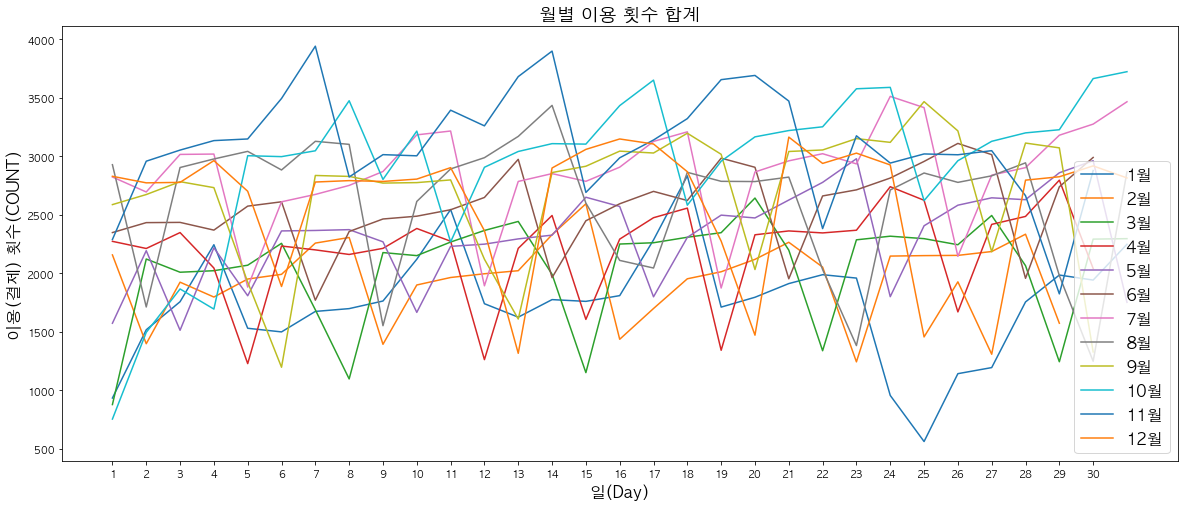

In [20]:
plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1.index, y=parking_1.values)
sns.lineplot(x=parking_2.index, y=parking_2.values)
sns.lineplot(x=parking_3.index, y=parking_3.values)
sns.lineplot(x=parking_4.index, y=parking_4.values)
sns.lineplot(x=parking_5.index, y=parking_5.values)
sns.lineplot(x=parking_6.index, y=parking_6.values)
sns.lineplot(x=parking_7.index, y=parking_7.values)
sns.lineplot(x=parking_8.index, y=parking_8.values)
sns.lineplot(x=parking_9.index, y=parking_9.values)

sns.lineplot(x=parking_10.index, y=parking_10.values)
sns.lineplot(x=parking_11.index, y=parking_11.values)
sns.lineplot(x=parking_12.index, y=parking_12.values)

plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1월', '2월', '3월', '4월','5월','6월','7월','8월','9월', '10월','11월','12월'], loc='best', fontsize=16)
plt.title('월별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수(COUNT)', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

##### 분기별 

In [21]:
#월별로 보자니 복잡해서 분기별 혹은 계절별로 나눠보기로 함 

#분기 
data['quartile']=data['Month'].apply(lambda x : 1 if x<=3 else 2 if (x>3) & (x<=6) else 3 if (x>6) & (x<=9) else 4)

In [22]:
#분기별 
parking_1_4=data[data.quartile==1]['COUNT'].groupby(data.Day).sum()
parking_2_4=data[data.quartile==2]['COUNT'].groupby(data.Day).sum()
parking_3_4=data[data.quartile==3]['COUNT'].groupby(data.Day).sum()
parking_4_4=data[data.quartile==4]['COUNT'].groupby(data.Day).sum()

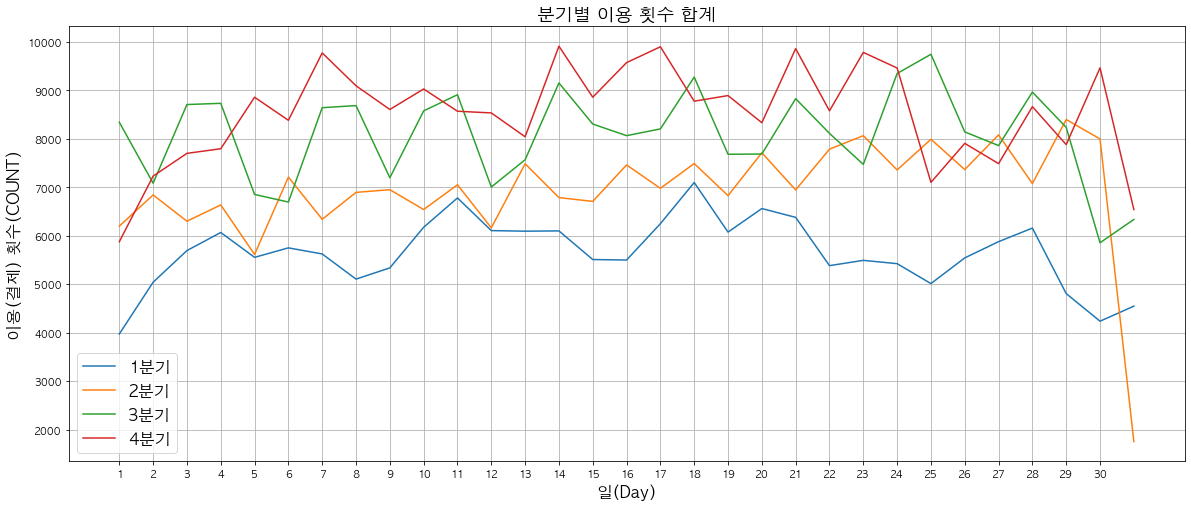

In [23]:
plt.figure(figsize=(20,8))
sns.lineplot(x=parking_1_4.index, y=parking_1_4.values)
sns.lineplot(x=parking_2_4.index, y=parking_2_4.values)
sns.lineplot(x=parking_3_4.index, y=parking_3_4.values)
sns.lineplot(x=parking_4_4.index, y=parking_4_4.values)

plt.grid()
plt.xticks(np.arange(1, 31, step=1))
plt.legend(['1분기', '2분기','3분기','4분기'], loc='best', fontsize=16)
plt.title('분기별 이용 횟수 합계', fontsize=18)
plt.ylabel('이용(결제) 횟수(COUNT)', fontsize=16)
plt.xlabel('일(Day)', fontsize=16)
plt.show();

# 1분기가 항상 낮고 3, 4분기가 엎치락 뒤치락함. 

In [24]:
# 딱히 seasonality, trend는 없음. cyclical 하기만 함. 
def plot_decompose(decomposerresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))
    decomposerresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observed')
    decomposerresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposerresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposerresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('Resid')

In [ ]:
result = seasonal_decompose(parking_1_4, model = 'additive', period=1)
plot_decompose(result)

In [ ]:
result = seasonal_decompose(parking_2_4, model = 'additive', period=1)
plot_decompose(result)

In [ ]:
result = seasonal_decompose(parking_3_4, model = 'additive', period=1)
plot_decompose(result)

In [ ]:
result = seasonal_decompose(parking_4_4, model = 'additive', period=1)
plot_decompose(result)

##### 요일별

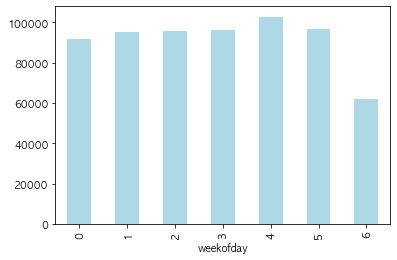

In [25]:
train.groupby('weekofday')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('weekofday')['COUNT'].sum().plot(kind='bar', color='lightblue');
#0부터 순차적으로 월~일 
#대체로 비슷하고 일요일에 덜 함 

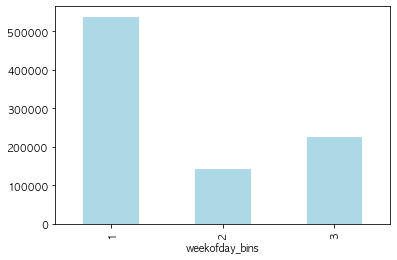

In [26]:
data['weekofday_bins']=data['weekofday'].apply(lambda x : 1 if x<=3 else 2 if x==4 else 3)
data.groupby('weekofday_bins')['COUNT'].sum().plot(kind='bar', color='lightblue');

# 1 : 월~목,  2: 금,  3: 토일 

##### GOODS_TYPE별 

In [ ]:
data.columns

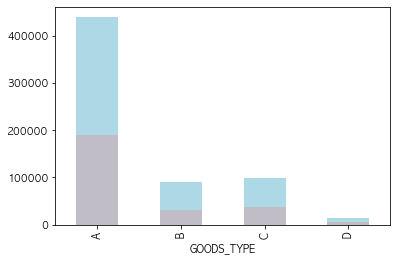

In [27]:
train.groupby('GOODS_TYPE')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('GOODS_TYPE')['COUNT'].sum().plot(kind='bar', color='lightcoral', alpha=0.3);

##### D_TYPE별 

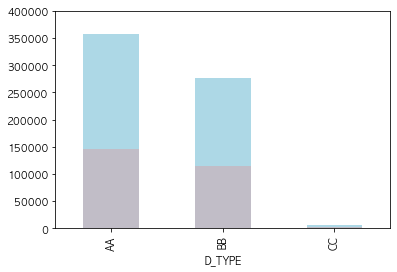

In [28]:
train.groupby('D_TYPE')['COUNT'].sum().plot(kind='bar', color='lightblue');
test.groupby('D_TYPE')['COUNT'].sum().plot(kind='bar', color='lightcoral', alpha=0.3, ylim=(0,400000));

In [29]:
data['JOIN_DAYS']=datetime(2020,12,31)-data['JOIN_DATE']
data['JOIN_DAYS']=data['JOIN_DAYS'].dt.days

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='JOIN_DAYS', y='COUNT', data=data[(data.DATE <'2020-09-01')&(data.JOIN_DAYS<5000)])   #outliers 제거하고 
sns.scatterplot(x='JOIN_DAYS', y='COUNT', data=data[(data.DATE >='2020-09-01')&(data.JOIN_DAYS<5000)])
plt.legend(['train', 'test'])
plt.show();

# train으로 잡히지 않는 test.. 

## Correlation

### Given set + month, day, weekofday, Join days, quartile

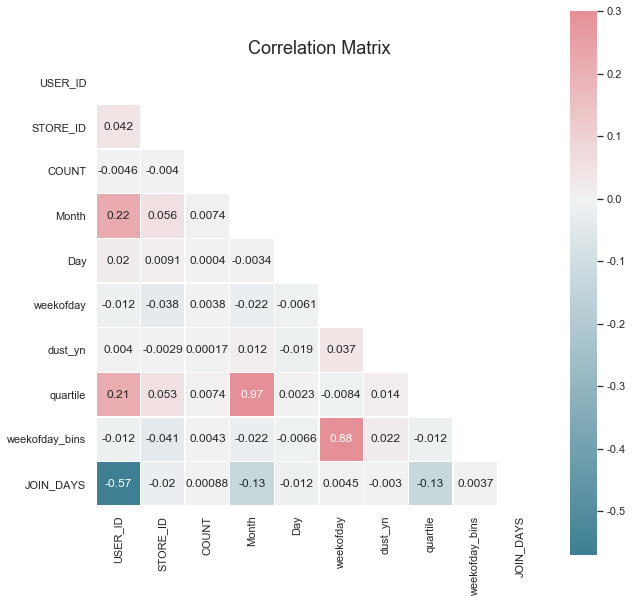

In [30]:
sns.set(style="white")
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

### + weather_day



In [ ]:
data_weather=pd.merge(data, weather_day, left_on='DATE', right_on='weather_date')

In [ ]:
data_weather.columns

In [ ]:
data_weather_corr=data_weather.corr()

In [ ]:
sns.set(style="white")
mask = np.triu(np.ones_like(data_weather_corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix - COUNT & Weather', fontsize=18)
sns.heatmap(data_weather_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()


- train, test set의 COUNT간 특정 구간에 대한 분포차이가 있음. (train에는 없고 test에는 있는 구간) 이 구간에 속한 데이터들을 어떻게 해야할지 논의 필요  
- 거의 모든 COUNT가 1에 몰려있음 
- 시계열 데이터 특성을 사용한 분석이 필요한건지? 가능한건지? cyclical이 보이긴 한데 요것만 취해서 분석에 활용할 수 있는건지?  
- ID 컬럼 - 버리는 경우, 취하는 경우 모두 테스트 해 봐야할 듯?  
- D_TYPE, GOODS_TYPE, AD1 에 대한 정확한 정보 필요 
- 1차적으로는 COUNT 컬럼과 크게 상관있는 피처가 없어보임. Month제외하고. 그러니 외부 데이터를 활용해야 할 것 같은데 어떻게 활용할 건지? - 날씨 데이터 중 취할 피처, 교통량 정보는 어떻게 처리할건지   
  
    
-------------------  
  
**5/10 회의 결과 - 각자 모델 돌려보기**  

- 독립: AD1, dtype, goods type
- 1팀 김나영, 박근웅: 가입한지 얼마나 오래됐나
- 2팀 김태영, 이해강 : 요일, 공휴일
- 3팀 조아라, 정우주, 오병훈 : 일평균 기온

## Baseline Modeling  
### Score Boards

|Set|labeling|model|avg val MSE/MAE|test MSE/MAE|개별 Kfolds| 
|---|-----|---------|-----------|--------|------|
|Basic Set|label| RF|0.14/0.04|0.32/0.05|
|+AvgTemp|label| RF|0.14/|0.32/|
|+AvgTemp|label| LR| 0.18/| 0.45/|
|+AvgTemp|label| LGBM| 0.14/| 0.34/|
|+AvgTemp,Rain,Snow|label|RF|0.14/|0.33/|mean of all
|+AvgTemp,Rain,Snow|dum (Rain, snow)|RF|0.14/0.04|0.32/0.05|
|+JOIN_DAYS|label|RF|0.046/0.040|0.109/0.048
|" +dust|dum(dust)|RF|0.046/0.040|0.109/0.048
|"|dum(dust)|LGBM|0.046/0.04|0.105/0.047
|" +traffic|dum(dust),St(traffic)|RF|0.046/0.040|0.105/0.047
|"|LGBM|0.044/0.039|0.102/0.047|  
|+JOIN_DAYS,dust,traffic,moving|dum(dust)|LGBM|0.042/0.038|0.102/0.047|  
|+JOIN_DAYS,dust,traffic,moving,parking_area,parking_range|dum(dust)|LGBM|0.041/0.038|0.095/0.048|  
| " | " | " | - |0.094/0.047|Kfold[0]|
| " | " | " | - |0.092/0.047|적용안함|
| " + frequency| " | " | - |0.091/0.046|적용안함|  

  
*dum(dust) = 경기 및 서울권 미세먼지 경보여부 1=있음 0=없음  
*moving = 유저별 이동범위 (store_id 빈도수)  
*parking_area = store_id 중 뒷자리 수 세 개를 제외한 앞자리 2~3개 (store_id가 1자리, 혹은 3자리 수라 빈칸으로 처리되는 건 0으로 일괄처리)  
*parking_range = 유저별 parking_area 빈도수



### DataSet 
#### Basic Set   
- AD1, dtype, goodstype, Month, DAy

In [31]:
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID',  'DATE',
            'weekofday', 'quartile','weekofday_bins', 'JOIN_DAYS']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + AvgTemp + rainfall_day, snow_day  
- rainfall_day, snow_day : 연속형 변수 - 별차이X  
- rainfall_day, snow_day : 범주형 변수/pd.getdummmies - 0.33으로 연속형과 별 차이 없음.

In [ ]:
data_weather['snow_day'].fillna(0, inplace=True)
data_weather['rainfall_Day'].fillna(0, inplace=True)

data_weather=pd.get_dummies(data_weather, columns=['rain_yn'])
data_weather=pd.get_dummies(data_weather, columns=['snow_yn'])

test=data_weather[data_weather['DATE']>='2020-10-01']
train = data_weather[data_weather['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID',  'DATE',
            'weekofday', 'quartile','weekofday_bins', 'JOIN_DAYS', 
          'point', 'weather_date', 'rainfall_Day','snow_day',
        'avgWind', 'avgHumid', 'du_sunshine',
        'snow_3h', 'avg5cm', 'avg10cm']


temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + JOIN DAYS  
- 2020.12.31 기준 가입 기간(일)

In [ ]:
test=data_weather[data_weather['DATE']>='2020-10-01']
train = data_weather[data_weather['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID',  'DATE',
            'weekofday', 'quartile','weekofday_bins', 
          'point', 'weather_date', 'rainfall_Day','snow_day',
        'avgWind', 'avgHumid', 'du_sunshine', 'avgTemp',
        'snow_3h', 'avg5cm', 'avg10cm', 'rain_yn_0', 'rain_yn_1', 'snow_yn_0',
       'snow_yn_1']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

#### Basic Set + JOIN DAYS + dust 

In [ ]:
data.columns

In [35]:
data=pd.get_dummies(data, columns=['dust_yn'])
test=data[data['DATE']>='2020-10-01']
train = data[data['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID','weekofday_bins', 'quartile',
            'DATE'
          ]

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

In [36]:
temp_basic_train

,D_TYPE,GOODS_TYPE,COUNT,AD1,Month,Day,weekofday,JOIN_DAYS,dust_yn_0,dust_yn_1
0,AA,A,1,GN,1,1,2,2550,1,0
1,BB,A,1,J,1,1,2,2512,1,0
2,BB,A,1,SC,1,1,2,2233,1,0
3,BB,C,1,MP,1,1,2,2219,1,0
4,AA,C,1,JRR,1,1,2,2216,1,0
...,...,...,...,...,...,...,...,...,...,...
623574,BB,B,1,GN,9,30,2,92,1,0
623575,AA,B,1,MP,9,30,2,92,1,0
623576,AA,B,1,BF,9,30,2,92,1,0
623577,BB,A,2,JRR,9,30,2,92,1,0


#### Basic Set + Joindays, Traffic 

In [37]:
data_traffic=pd.merge(data, traffic, left_on='DATE', right_on='DATE')

In [39]:
# data_traffic=pd.get_dummies(data_traffic, columns=['dust_yn'])
test=data_traffic[data_traffic['DATE']>='2020-10-01']
train = data_traffic[data_traffic['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID', 'DATE']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

In [45]:
temp_basic_train

,D_TYPE,GOODS_TYPE,COUNT,AD1,Month,Day,weekofday,quartile,weekofday_bins,JOIN_DAYS,dust_yn_0,dust_yn_1,합계,moving
0,AA,A,1,GN,1,1,2,1,1,2550,1,0,7347299.0,1
1,BB,A,1,J,1,1,2,1,1,2512,1,0,7347299.0,2
2,BB,A,1,SC,1,1,2,1,1,2233,1,0,7347299.0,3
3,BB,C,1,MP,1,1,2,1,1,2219,1,0,7347299.0,30
4,AA,C,1,JRR,1,1,2,1,1,2216,1,0,7347299.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623574,BB,B,1,GN,9,30,2,3,1,92,1,0,7129682.0,4
623575,AA,B,1,MP,9,30,2,3,1,92,1,0,7129682.0,1
623576,AA,B,1,BF,9,30,2,3,1,92,1,0,7129682.0,1
623577,BB,A,2,JRR,9,30,2,3,1,92,1,0,7129682.0,1


#### Basic Set + Join days + dust_yn + Traffic + 유저별 이동범위? 

In [158]:
data_traffic['moving']=data_traffic.groupby('USER_ID')['STORE_ID'].transform('nunique')

In [44]:
test=data_traffic[data_traffic['DATE']>='2020-10-01']
train = data_traffic[data_traffic['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID', 'DATE']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

In [ ]:
pd.options.display.max_rows=100000
data[['STORE_ID','AD1']].sort_values('STORE_ID', ascending=False).head(10000)

#### Basic Set + Join days + dust_yn + Traffic + 유저별 이동범위 + 주차지역 + 유저 빈도수 

In [120]:
data_traffic['parking_area']=data_traffic['STORE_ID'].astype(str).str[:-3]

In [121]:
data_traffic['parking_area'].replace('', '0', inplace=True)

In [122]:
data_traffic['parking_area'].unique()

array(['1', '182', '82', '0', '220', '91', '109', '131', '2', '190',
       '172', '102', '92', '90', '110', '105', '204', '106', '219', '104',
       '203', '27', '181', '93', '96', '157', '207', '137', '108', '173',
       '186', '28', '97', '111', '188', '189', '101', '205', '183', '107',
       '185', '184', '132', '83', '48', '221', '133', '222', '158', '223',
       '136', '225', '227', '228', '67', '229', '230', '68', '231'],
      dtype=object)

In [123]:
data_traffic['parking_range']=data_traffic.groupby('USER_ID')['parking_area'].transform('nunique')

In [151]:
data_traffic['frequency']=data_traffic.groupby('USER_ID')['USER_ID'].transform('count')

In [156]:
# data_traffic[data_traffic['USER_ID']==999665]

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,Month,Day,...,quartile,weekofday_bins,JOIN_DAYS,dust_yn_0,dust_yn_1,합계,moving,parking_area,parking_range,frequency
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,1,1,...,1,1,746,1,0,7347299.0,366,82,38,366
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,1,2,...,1,1,746,1,0,9326734.0,366,104,38,366
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,1,3,...,1,2,746,0,1,9998638.0,366,181,38,366
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,1,4,...,1,3,746,1,0,9198233.0,366,109,38,366
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,1,5,...,1,3,746,1,0,7868358.0,366,104,38,366
8390,999665,2018-12-16,CC,109423,A,2020-01-06,11,J,1,6,...,1,1,746,1,0,9430786.0,366,109,38,366
9928,999665,2018-12-16,CC,106153,A,2020-01-07,9,J,1,7,...,1,1,746,1,0,9223871.0,366,106,38,366
11552,999665,2018-12-16,CC,91992,A,2020-01-08,13,YD,1,8,...,1,1,746,1,0,9655170.0,366,91,38,366
13247,999665,2018-12-16,CC,106153,A,2020-01-09,12,J,1,9,...,1,1,746,1,0,9992140.0,366,106,38,366
15061,999665,2018-12-16,CC,109400,A,2020-01-10,21,J,1,10,...,1,2,746,1,0,10208995.0,366,109,38,366


In [162]:
# temp_basic_train.head(100)

In [91]:
# data.sort_values('AD1').groupby('AD1')['USER_ID'].nunique()

In [159]:
test=data_traffic[data_traffic['DATE']>='2020-10-01']
train = data_traffic[data_traffic['DATE']<'2020-10-01']

target_col='COUNT'
drop_cols=['USER_ID', 'JOIN_DATE', 'STORE_ID', 'DATE']

# --------------- Basic Set : D_TYPE, GOODS_TYPE, AD1
temp_basic_train = train.drop(drop_cols,1)
temp_basic_test = test.drop(drop_cols,1)

### Label Encoding & Train/Test split

In [163]:
# Label Encoding 
cat_cols=['D_TYPE', 'GOODS_TYPE', 'AD1', 'parking_area', 'parking_range']
lbl = LabelEncoder()

for col in tqdm(cat_cols):
    temp_df=pd.concat([temp_basic_train, temp_basic_test])
    lbl.fit(temp_df[col]) 
    temp_basic_train[col]=lbl.transform(temp_basic_train[col])
    temp_basic_test[col]=lbl.transform(temp_basic_test[col])
    

  0%|          | 0/5 [00:00<?, ?it/s]

#### train/ test split

In [164]:
# training set 
temp_basic_train_X = temp_basic_train.drop(target_col,1)
temp_basic_train_y = temp_basic_train[target_col]

# test set 
temp_basic_test_X = temp_basic_test.drop(target_col,1)
temp_basic_test_y = temp_basic_test[target_col]

In [172]:
temp_basic_train_X.shape

(623579, 16)

In [171]:
temp_basic_test_X.shape

(255692, 16)

### Basic Hypter Parameters, CV

In [128]:
cv_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
cv = KFold(n_splits=5, shuffle=True, random_state=11)

In [ ]:
# # gradient boosted trees tend to do well on problems like this
# # reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

# from skopt.space import Real, Integer
# from skopt.utils import use_named_args
# from skopt import gp_minimize
# from sklearn.model_selection import cross_val_score

# rg = RandomForestRegressor(n_estimators=1000, random_state=11)

# # The list of hyper-parameters we want to optimize. For each one we define the
# # bounds, the corresponding scikit-learn parameter name, as well as how to
# # sample values from that dimension (`'log-uniform'` for the learning rate)
# space  = [Integer(1, 50, name='max_depth'),
# #           Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
# #           Integer(1, n_features, name='max_features'),
#           Integer(2, 100, name='min_samples_split'),
#           Integer(1, 100, name='min_samples_leaf')]


# @use_named_args(space)
# def objective(**params):
#     rg.set_params(**params)
#     return -np.mean(cross_val_score(rg, temp_basic_train_X, temp_basic_train_y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error'))

# from skopt import gp_minimize
# res_gp = gp_minimize(objective, space, n_calls=50, random_state=11)

# "Best score=%.4f" % res_gp.fun

In [129]:
# light gbm
hyper_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.005,
    'verbose': -1,
    "max_depth": 10,
    "num_leaves": 100,  
    "n_estimators": 1000
}

### RF Regressor

In [ ]:
# --- model (1) RF Regressor 

rf_mse=[]
rf_mae=[]
# rf_models={}

X=temp_basic_train_X
y=temp_basic_train_y

for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
    trn_data, trn_label = X.iloc[trn_idx], y.iloc[trn_idx]
    val_data, val_label = X.iloc[val_idx], y.iloc[val_idx]


    print(f'========== {i} Fold ==========')
    
    print(f'TRAINING RF Regressor')
    rf_model=RandomForestRegressor(
        n_estimators=1000,
        max_depth=5,
        random_state=11,
        n_jobs=-1).fit(trn_data,trn_label)

    rf_trn_pred = rf_model.predict(trn_data)
    rf_trn_mse = mean_squared_error(rf_trn_pred, trn_label)
    rf_trn_mae = mean_absolute_error(rf_trn_pred, trn_label)
    
    rf_val_pred = rf_model.predict(val_data)
    rf_val_mse = mean_squared_error(rf_val_pred, val_label)
    rf_val_mae = mean_absolute_error(rf_val_pred, val_label)
    
    print(f'train mse : {rf_trn_mse}, train mae : {rf_trn_mae}')
    print(f'val mse : {rf_val_mse}, val mae : {rf_val_mae}')
    print()
    
    rf_mse.append(rf_val_mse)
    rf_mae.append(rf_val_mae)
#     rf_models[i]=rf_model

print(f'Average mse of Val Set : {np.mean(rf_mse)}')
print(f'Average mae of Val Set : {np.mean(rf_mae)}')


rf_test_pred= rf_model.predict(temp_basic_test_X)
rf_test_mse = mean_squared_error(rf_test_pred, temp_basic_test_y)
rf_test_mae = mean_absolute_error(rf_test_pred, temp_basic_test_y)

print(f'Mse of Test Set : {rf_test_mse}')
print(f'Mae of Test Set : {rf_test_mae}')

In [ ]:
temp_basic_train_X

In [ ]:
# #test with each fold -> means 
# rf_mse=[]
# for fold in range(5):
#     rf_test_pred= rf_models[fold].predict(temp_basic_test_X)
#     rf_test_mse = mean_squared_error(rf_test_pred, temp_basic_test_y)
#     rf_mse.append(rf_test_mse)
    
# print(np.mean(rf_mse))

In [ ]:
print(f'Average rmse of Test Set : {np.sqrt(rf_test_mse)}')
print(f'Average rmse of Val Set : {np.sqrt(np.mean(rf_mse))}')

### Linear

In [ ]:
# # --- model (2) Linear Regressor 

# lr_mse=[]

# for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
#     trn_data, trn_label = temp_basic_train_X.iloc[trn_idx], temp_basic_train_y.iloc[trn_idx]
#     val_data, val_label = temp_basic_train_X.iloc[val_idx], temp_basic_train_y.iloc[val_idx]


#     print(f'========== {i} Fold ==========')
    
#     print(f'TRAINING LR Regressor')
#     lr_model=LinearRegression(
#         n_jobs=-1).fit(trn_data,trn_label)

#     lr_trn_pred = lr_model.predict(trn_data)
#     lr_trn_mse = mean_squared_error(lr_trn_pred, trn_label)
    
#     lr_val_pred = lr_model.predict(val_data)
#     lr_val_mse = mean_squared_error(lr_val_pred, val_label)
    
#     print(f'train mse : {lr_trn_mse}')
#     print(f'val mse : {lr_val_mse}')
#     print()
    
#     lr_mse.append(lr_val_mse)

# print(f'Average mse of Val Set : {np.mean(lr_mse)}')


# #test 
# lr_test_pred = lr_model.predict(temp_basic_test_X)
# lr_test_mse = mean_squared_error(lr_test_pred, temp_basic_test_y)
# print(lr_test_mse)

In [ ]:
# # --- model (2) Linear Regressor  -No Kfold 

# lr_mse=[]

# lr_model=LinearRegression(
#     n_jobs=-1).fit(temp_basic_train_X,temp_basic_train_y)

# train_pred = lr_model.predict(temp_basic_train_X)
# train_mse = mean_squared_error(train_pred, temp_basic_train_y)

# print(f'train mse : {train_mse}')

# print()
    

# #test 
# test_pred = lr_model.predict(temp_basic_test_X)
# test_mse = mean_squared_error(test_pred, temp_basic_test_y)
# print(test_mse)


# train mse : 0.18124601978881402
# test mse : 0.4588413524970711

### Lgbm

In [131]:
# --- model (2) Linear Regressor 

lg_mse=[]
lg_mae=[]

lg_models={}

X=temp_basic_train_X
y=temp_basic_train_y

for i , (trn_idx, val_idx) in tqdm(enumerate(cv_s.split(X=X, y=y))):
    trn_data, trn_label = X.iloc[trn_idx], y.iloc[trn_idx]
    val_data, val_label = X.iloc[val_idx], y.iloc[val_idx]


    print(f'========== {i} Fold ==========')
    
    print(f'TRAINING LGBM Regressor')
    lg_model=lgbm.LGBMRegressor(**hyper_params)
    
    lg_model.fit(trn_data, trn_label,
        eval_set=[(val_data, val_label)],
        eval_metric='l1',
        early_stopping_rounds=500)

    lg_trn_pred = lg_model.predict(trn_data, num_iteration=lg_model.best_iteration_)
    lg_trn_mse = mean_squared_error(lg_trn_pred, trn_label)
    lg_trn_mae = mean_absolute_error(lg_trn_pred, trn_label)
    
    lg_val_pred = lg_model.predict(val_data, num_iteration=lg_model.best_iteration_)
    lg_val_mse = mean_squared_error(lg_val_pred, val_label)
    lg_val_mae = mean_absolute_error(lg_val_pred, val_label)
    
    print(f'train mse : {lg_trn_mse}, train mae : {lg_trn_mae}')
    print(f'val mse : {lg_val_mse}, , val mae : {lg_val_mae}')
    print()
    
    lg_mse.append(lg_val_mse)
    lg_mae.append(lg_val_mae)
    lg_models[i]=lg_model

print(f'Average mse of Val Set : {np.mean(lg_mse)}')
print(f'Average mae of Val Set : {np.mean(lg_mae)}')


#test 
lg_test_pred = lg_model.predict(temp_basic_test_X, num_iteration=lg_model.best_iteration_)
lg_test_mse = mean_squared_error(lg_test_pred, temp_basic_test_y)
lg_test_mae = mean_absolute_error(lg_test_pred, temp_basic_test_y)

print(f'MSE of Test set : {lg_test_mse}')
print(f'MAE of Test set : {lg_test_mae}')
      

0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


========== 0 Fold ==========
TRAINING LGBM Regressor
[1]	valid_0's l1: 0.0529121	valid_0's l2: 0.173425
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l1: 0.0528324	valid_0's l2: 0.17202
[3]	valid_0's l1: 0.0527533	valid_0's l2: 0.170633
[4]	valid_0's l1: 0.0526744	valid_0's l2: 0.169256
[5]	valid_0's l1: 0.0525958	valid_0's l2: 0.167897
[6]	valid_0's l1: 0.0525177	valid_0's l2: 0.166549
[7]	valid_0's l1: 0.0524399	valid_0's l2: 0.165218
[8]	valid_0's l1: 0.0523626	valid_0's l2: 0.163897
[9]	valid_0's l1: 0.0522856	valid_0's l2: 0.162593
[10]	valid_0's l1: 0.0522089	valid_0's l2: 0.161299
[11]	valid_0's l1: 0.0521329	valid_0's l2: 0.160021
[12]	valid_0's l1: 0.052057	valid_0's l2: 0.158754
[13]	valid_0's l1: 0.0519818	valid_0's l2: 0.157502
[14]	valid_0's l1: 0.0519066	valid_0's l2: 0.156259
[15]	valid_0's l1: 0.0518309	valid_0's l2: 0.155032
[16]	valid_0's l1: 0.0517552	valid_0's l2: 0.153813
[17]	valid_0's l1: 0.0516801	valid_0's l2: 0.152609
[18]	valid_0

[156]	valid_0's l1: 0.0443381	valid_0's l2: 0.0647289
[157]	valid_0's l1: 0.0443033	valid_0's l2: 0.0644663
[158]	valid_0's l1: 0.0442668	valid_0's l2: 0.0641691
[159]	valid_0's l1: 0.0442335	valid_0's l2: 0.0639152
[160]	valid_0's l1: 0.0441983	valid_0's l2: 0.0636425
[161]	valid_0's l1: 0.0441639	valid_0's l2: 0.0633769
[162]	valid_0's l1: 0.0441301	valid_0's l2: 0.0631115
[163]	valid_0's l1: 0.0440966	valid_0's l2: 0.0628652
[164]	valid_0's l1: 0.0440608	valid_0's l2: 0.0625996
[165]	valid_0's l1: 0.0440275	valid_0's l2: 0.0623477
[166]	valid_0's l1: 0.0439937	valid_0's l2: 0.0620903
[167]	valid_0's l1: 0.0439601	valid_0's l2: 0.0618351
[168]	valid_0's l1: 0.0439264	valid_0's l2: 0.0615817
[169]	valid_0's l1: 0.0438934	valid_0's l2: 0.0613496
[170]	valid_0's l1: 0.0438594	valid_0's l2: 0.0611004
[171]	valid_0's l1: 0.0438282	valid_0's l2: 0.0608755
[172]	valid_0's l1: 0.0437952	valid_0's l2: 0.0606315
[173]	valid_0's l1: 0.0437637	valid_0's l2: 0.0603971
[174]	valid_0's l1: 0.043732

[310]	valid_0's l1: 0.0409035	valid_0's l2: 0.0430879
[311]	valid_0's l1: 0.0408908	valid_0's l2: 0.0430335
[312]	valid_0's l1: 0.0408777	valid_0's l2: 0.0429695
[313]	valid_0's l1: 0.0408653	valid_0's l2: 0.0429072
[314]	valid_0's l1: 0.0408537	valid_0's l2: 0.0428548
[315]	valid_0's l1: 0.0408415	valid_0's l2: 0.0427926
[316]	valid_0's l1: 0.0408294	valid_0's l2: 0.0427422
[317]	valid_0's l1: 0.040818	valid_0's l2: 0.0426916
[318]	valid_0's l1: 0.0408065	valid_0's l2: 0.0426433
[319]	valid_0's l1: 0.0407953	valid_0's l2: 0.0425836
[320]	valid_0's l1: 0.0407825	valid_0's l2: 0.0425224
[321]	valid_0's l1: 0.0407709	valid_0's l2: 0.042475
[322]	valid_0's l1: 0.0407598	valid_0's l2: 0.0424255
[323]	valid_0's l1: 0.0407482	valid_0's l2: 0.0423671
[324]	valid_0's l1: 0.0407363	valid_0's l2: 0.0423183
[325]	valid_0's l1: 0.0407254	valid_0's l2: 0.042263
[326]	valid_0's l1: 0.0407142	valid_0's l2: 0.042218
[327]	valid_0's l1: 0.0407023	valid_0's l2: 0.0421706
[328]	valid_0's l1: 0.0406916	va

[465]	valid_0's l1: 0.03964	valid_0's l2: 0.0382053
[466]	valid_0's l1: 0.039636	valid_0's l2: 0.0381942
[467]	valid_0's l1: 0.0396316	valid_0's l2: 0.0381876
[468]	valid_0's l1: 0.0396276	valid_0's l2: 0.038176
[469]	valid_0's l1: 0.0396233	valid_0's l2: 0.0381706
[470]	valid_0's l1: 0.0396189	valid_0's l2: 0.0381597
[471]	valid_0's l1: 0.0396145	valid_0's l2: 0.0381545
[472]	valid_0's l1: 0.03961	valid_0's l2: 0.0381435
[473]	valid_0's l1: 0.0396061	valid_0's l2: 0.0381375
[474]	valid_0's l1: 0.0396015	valid_0's l2: 0.038124
[475]	valid_0's l1: 0.0395968	valid_0's l2: 0.038113
[476]	valid_0's l1: 0.0395926	valid_0's l2: 0.0381085
[477]	valid_0's l1: 0.0395882	valid_0's l2: 0.0380988
[478]	valid_0's l1: 0.0395843	valid_0's l2: 0.0380942
[479]	valid_0's l1: 0.0395803	valid_0's l2: 0.0380836
[480]	valid_0's l1: 0.0395755	valid_0's l2: 0.03808
[481]	valid_0's l1: 0.0395719	valid_0's l2: 0.0380709
[482]	valid_0's l1: 0.0395673	valid_0's l2: 0.0380659
[483]	valid_0's l1: 0.0395622	valid_0'

[624]	valid_0's l1: 0.0391385	valid_0's l2: 0.037672
[625]	valid_0's l1: 0.0391365	valid_0's l2: 0.0376719
[626]	valid_0's l1: 0.0391348	valid_0's l2: 0.0376757
[627]	valid_0's l1: 0.0391322	valid_0's l2: 0.0376754
[628]	valid_0's l1: 0.0391307	valid_0's l2: 0.037677
[629]	valid_0's l1: 0.0391288	valid_0's l2: 0.037677
[630]	valid_0's l1: 0.0391266	valid_0's l2: 0.0376746
[631]	valid_0's l1: 0.0391244	valid_0's l2: 0.0376739
[632]	valid_0's l1: 0.0391229	valid_0's l2: 0.037675
[633]	valid_0's l1: 0.0391203	valid_0's l2: 0.0376748
[634]	valid_0's l1: 0.0391187	valid_0's l2: 0.0376785
[635]	valid_0's l1: 0.0391165	valid_0's l2: 0.0376779
[636]	valid_0's l1: 0.0391153	valid_0's l2: 0.0376805
[637]	valid_0's l1: 0.0391129	valid_0's l2: 0.0376754
[638]	valid_0's l1: 0.0391111	valid_0's l2: 0.0376753
[639]	valid_0's l1: 0.039109	valid_0's l2: 0.0376761
[640]	valid_0's l1: 0.0391069	valid_0's l2: 0.0376729
[641]	valid_0's l1: 0.0391052	valid_0's l2: 0.0376727
[642]	valid_0's l1: 0.0391033	val

[781]	valid_0's l1: 0.0389006	valid_0's l2: 0.0376909
[782]	valid_0's l1: 0.0388989	valid_0's l2: 0.0376898
[783]	valid_0's l1: 0.0388968	valid_0's l2: 0.0376852
[784]	valid_0's l1: 0.0388954	valid_0's l2: 0.0376875
[785]	valid_0's l1: 0.0388949	valid_0's l2: 0.0376924
[786]	valid_0's l1: 0.038894	valid_0's l2: 0.0376931
[787]	valid_0's l1: 0.0388924	valid_0's l2: 0.03769
[788]	valid_0's l1: 0.0388915	valid_0's l2: 0.0376897
[789]	valid_0's l1: 0.0388904	valid_0's l2: 0.0376939
[790]	valid_0's l1: 0.0388891	valid_0's l2: 0.0376925
[791]	valid_0's l1: 0.0388887	valid_0's l2: 0.0376974
[792]	valid_0's l1: 0.0388876	valid_0's l2: 0.0376965
[793]	valid_0's l1: 0.0388858	valid_0's l2: 0.0376938
[794]	valid_0's l1: 0.0388847	valid_0's l2: 0.0376935
[795]	valid_0's l1: 0.0388845	valid_0's l2: 0.0376984
[796]	valid_0's l1: 0.0388836	valid_0's l2: 0.0377004
[797]	valid_0's l1: 0.038882	valid_0's l2: 0.0376989
[798]	valid_0's l1: 0.0388816	valid_0's l2: 0.0377039
[799]	valid_0's l1: 0.0388807	va

[936]	valid_0's l1: 0.0387283	valid_0's l2: 0.0375749
[937]	valid_0's l1: 0.0387274	valid_0's l2: 0.0375738
[938]	valid_0's l1: 0.0387266	valid_0's l2: 0.0375706
[939]	valid_0's l1: 0.0387262	valid_0's l2: 0.0375731
[940]	valid_0's l1: 0.0387258	valid_0's l2: 0.0375751
[941]	valid_0's l1: 0.0387251	valid_0's l2: 0.0375768
[942]	valid_0's l1: 0.0387241	valid_0's l2: 0.0375736
[943]	valid_0's l1: 0.0387233	valid_0's l2: 0.0375755
[944]	valid_0's l1: 0.0387227	valid_0's l2: 0.0375775
[945]	valid_0's l1: 0.0387215	valid_0's l2: 0.0375735
[946]	valid_0's l1: 0.0387204	valid_0's l2: 0.0375712
[947]	valid_0's l1: 0.0387195	valid_0's l2: 0.0375676
[948]	valid_0's l1: 0.0387179	valid_0's l2: 0.0375691
[949]	valid_0's l1: 0.0387177	valid_0's l2: 0.0375717
[950]	valid_0's l1: 0.0387171	valid_0's l2: 0.0375719
[951]	valid_0's l1: 0.0387148	valid_0's l2: 0.0375682
[952]	valid_0's l1: 0.0387127	valid_0's l2: 0.0375637
[953]	valid_0's l1: 0.0387123	valid_0's l2: 0.037566
[954]	valid_0's l1: 0.0387114

[90]	valid_0's l1: 0.0473005	valid_0's l2: 0.105509
[91]	valid_0's l1: 0.0472505	valid_0's l2: 0.104953
[92]	valid_0's l1: 0.0472035	valid_0's l2: 0.104418
[93]	valid_0's l1: 0.0471568	valid_0's l2: 0.103882
[94]	valid_0's l1: 0.0471102	valid_0's l2: 0.103352
[95]	valid_0's l1: 0.0470609	valid_0's l2: 0.10282
[96]	valid_0's l1: 0.0470146	valid_0's l2: 0.102298
[97]	valid_0's l1: 0.0469689	valid_0's l2: 0.101786
[98]	valid_0's l1: 0.046923	valid_0's l2: 0.101271
[99]	valid_0's l1: 0.0468753	valid_0's l2: 0.100757
[100]	valid_0's l1: 0.0468303	valid_0's l2: 0.100267
[101]	valid_0's l1: 0.0467858	valid_0's l2: 0.099767
[102]	valid_0's l1: 0.046741	valid_0's l2: 0.0992817
[103]	valid_0's l1: 0.0466934	valid_0's l2: 0.0987868
[104]	valid_0's l1: 0.0466495	valid_0's l2: 0.0983119
[105]	valid_0's l1: 0.0466065	valid_0's l2: 0.0978494
[106]	valid_0's l1: 0.0465594	valid_0's l2: 0.0973648
[107]	valid_0's l1: 0.0465157	valid_0's l2: 0.096903
[108]	valid_0's l1: 0.0464708	valid_0's l2: 0.0964325


[243]	valid_0's l1: 0.0423991	valid_0's l2: 0.0630138
[244]	valid_0's l1: 0.0423796	valid_0's l2: 0.0628845
[245]	valid_0's l1: 0.0423618	valid_0's l2: 0.062779
[246]	valid_0's l1: 0.0423436	valid_0's l2: 0.0626739
[247]	valid_0's l1: 0.0423237	valid_0's l2: 0.0625633
[248]	valid_0's l1: 0.0423034	valid_0's l2: 0.0624338
[249]	valid_0's l1: 0.0422851	valid_0's l2: 0.0623269
[250]	valid_0's l1: 0.0422674	valid_0's l2: 0.0622217
[251]	valid_0's l1: 0.0422499	valid_0's l2: 0.0621132
[252]	valid_0's l1: 0.0422321	valid_0's l2: 0.0620084
[253]	valid_0's l1: 0.0422129	valid_0's l2: 0.0618854
[254]	valid_0's l1: 0.0421944	valid_0's l2: 0.0617873
[255]	valid_0's l1: 0.0421759	valid_0's l2: 0.0616842
[256]	valid_0's l1: 0.0421588	valid_0's l2: 0.0615809
[257]	valid_0's l1: 0.0421413	valid_0's l2: 0.0614822
[258]	valid_0's l1: 0.0421235	valid_0's l2: 0.0613668
[259]	valid_0's l1: 0.0421049	valid_0's l2: 0.0612634
[260]	valid_0's l1: 0.0420875	valid_0's l2: 0.0611637
[261]	valid_0's l1: 0.0420695

[399]	valid_0's l1: 0.0404714	valid_0's l2: 0.0534286
[400]	valid_0's l1: 0.0404631	valid_0's l2: 0.0534005
[401]	valid_0's l1: 0.0404562	valid_0's l2: 0.0533768
[402]	valid_0's l1: 0.0404477	valid_0's l2: 0.0533418
[403]	valid_0's l1: 0.0404388	valid_0's l2: 0.0533115
[404]	valid_0's l1: 0.0404312	valid_0's l2: 0.0532835
[405]	valid_0's l1: 0.0404229	valid_0's l2: 0.0532498
[406]	valid_0's l1: 0.0404146	valid_0's l2: 0.0532259
[407]	valid_0's l1: 0.0404061	valid_0's l2: 0.0531922
[408]	valid_0's l1: 0.0403973	valid_0's l2: 0.0531617
[409]	valid_0's l1: 0.0403893	valid_0's l2: 0.0531361
[410]	valid_0's l1: 0.0403815	valid_0's l2: 0.0531039
[411]	valid_0's l1: 0.0403738	valid_0's l2: 0.0530764
[412]	valid_0's l1: 0.040366	valid_0's l2: 0.0530507
[413]	valid_0's l1: 0.0403575	valid_0's l2: 0.0530228
[414]	valid_0's l1: 0.0403498	valid_0's l2: 0.0529914
[415]	valid_0's l1: 0.0403423	valid_0's l2: 0.0529675
[416]	valid_0's l1: 0.0403351	valid_0's l2: 0.0529458
[417]	valid_0's l1: 0.0403265

[556]	valid_0's l1: 0.0395564	valid_0's l2: 0.0499225
[557]	valid_0's l1: 0.0395525	valid_0's l2: 0.0499083
[558]	valid_0's l1: 0.0395485	valid_0's l2: 0.0498893
[559]	valid_0's l1: 0.0395435	valid_0's l2: 0.049875
[560]	valid_0's l1: 0.0395384	valid_0's l2: 0.0498579
[561]	valid_0's l1: 0.039535	valid_0's l2: 0.0498452
[562]	valid_0's l1: 0.03953	valid_0's l2: 0.0498283
[563]	valid_0's l1: 0.0395264	valid_0's l2: 0.0498137
[564]	valid_0's l1: 0.0395235	valid_0's l2: 0.0497983
[565]	valid_0's l1: 0.0395198	valid_0's l2: 0.0497838
[566]	valid_0's l1: 0.0395163	valid_0's l2: 0.0497688
[567]	valid_0's l1: 0.0395115	valid_0's l2: 0.0497512
[568]	valid_0's l1: 0.0395086	valid_0's l2: 0.0497393
[569]	valid_0's l1: 0.0395054	valid_0's l2: 0.0497229
[570]	valid_0's l1: 0.0395004	valid_0's l2: 0.049707
[571]	valid_0's l1: 0.039498	valid_0's l2: 0.0496916
[572]	valid_0's l1: 0.0394943	valid_0's l2: 0.049677
[573]	valid_0's l1: 0.0394918	valid_0's l2: 0.0496617
[574]	valid_0's l1: 0.0394887	valid

[712]	valid_0's l1: 0.0391515	valid_0's l2: 0.0485023
[713]	valid_0's l1: 0.0391504	valid_0's l2: 0.0485005
[714]	valid_0's l1: 0.0391485	valid_0's l2: 0.0484947
[715]	valid_0's l1: 0.0391474	valid_0's l2: 0.0484887
[716]	valid_0's l1: 0.0391466	valid_0's l2: 0.0484818
[717]	valid_0's l1: 0.0391453	valid_0's l2: 0.0484761
[718]	valid_0's l1: 0.0391443	valid_0's l2: 0.0484701
[719]	valid_0's l1: 0.0391429	valid_0's l2: 0.0484661
[720]	valid_0's l1: 0.0391419	valid_0's l2: 0.0484611
[721]	valid_0's l1: 0.0391407	valid_0's l2: 0.0484595
[722]	valid_0's l1: 0.0391386	valid_0's l2: 0.048453
[723]	valid_0's l1: 0.0391372	valid_0's l2: 0.0484473
[724]	valid_0's l1: 0.039136	valid_0's l2: 0.0484411
[725]	valid_0's l1: 0.0391343	valid_0's l2: 0.0484393
[726]	valid_0's l1: 0.0391335	valid_0's l2: 0.0484327
[727]	valid_0's l1: 0.0391325	valid_0's l2: 0.0484272
[728]	valid_0's l1: 0.0391311	valid_0's l2: 0.0484244
[729]	valid_0's l1: 0.0391299	valid_0's l2: 0.0484199
[730]	valid_0's l1: 0.0391284	

[865]	valid_0's l1: 0.0389748	valid_0's l2: 0.047966
[866]	valid_0's l1: 0.0389748	valid_0's l2: 0.0479664
[867]	valid_0's l1: 0.0389737	valid_0's l2: 0.0479686
[868]	valid_0's l1: 0.0389726	valid_0's l2: 0.0479632
[869]	valid_0's l1: 0.0389712	valid_0's l2: 0.0479609
[870]	valid_0's l1: 0.0389708	valid_0's l2: 0.0479627
[871]	valid_0's l1: 0.03897	valid_0's l2: 0.0479629
[872]	valid_0's l1: 0.0389696	valid_0's l2: 0.047966
[873]	valid_0's l1: 0.0389679	valid_0's l2: 0.0479631
[874]	valid_0's l1: 0.038967	valid_0's l2: 0.0479589
[875]	valid_0's l1: 0.0389662	valid_0's l2: 0.0479605
[876]	valid_0's l1: 0.0389652	valid_0's l2: 0.0479628
[877]	valid_0's l1: 0.0389639	valid_0's l2: 0.0479581
[878]	valid_0's l1: 0.0389625	valid_0's l2: 0.0479542
[879]	valid_0's l1: 0.038962	valid_0's l2: 0.0479519
[880]	valid_0's l1: 0.038961	valid_0's l2: 0.0479485
[881]	valid_0's l1: 0.0389606	valid_0's l2: 0.0479501
[882]	valid_0's l1: 0.0389595	valid_0's l2: 0.0479462
[883]	valid_0's l1: 0.0389588	valid

[14]	valid_0's l1: 0.0522194	valid_0's l2: 0.173136
[15]	valid_0's l1: 0.0521458	valid_0's l2: 0.171892
[16]	valid_0's l1: 0.0520725	valid_0's l2: 0.170684
[17]	valid_0's l1: 0.0519985	valid_0's l2: 0.169462
[18]	valid_0's l1: 0.0519273	valid_0's l2: 0.168279
[19]	valid_0's l1: 0.0518545	valid_0's l2: 0.16708
[20]	valid_0's l1: 0.0517839	valid_0's l2: 0.165919
[21]	valid_0's l1: 0.0517129	valid_0's l2: 0.164746
[22]	valid_0's l1: 0.051642	valid_0's l2: 0.163606
[23]	valid_0's l1: 0.0515716	valid_0's l2: 0.162455
[24]	valid_0's l1: 0.0515014	valid_0's l2: 0.161338
[25]	valid_0's l1: 0.0514318	valid_0's l2: 0.160209
[26]	valid_0's l1: 0.0513625	valid_0's l2: 0.159113
[27]	valid_0's l1: 0.0512935	valid_0's l2: 0.158007
[28]	valid_0's l1: 0.0512256	valid_0's l2: 0.156934
[29]	valid_0's l1: 0.0511563	valid_0's l2: 0.155847
[30]	valid_0's l1: 0.0510881	valid_0's l2: 0.154793
[31]	valid_0's l1: 0.0510207	valid_0's l2: 0.153743
[32]	valid_0's l1: 0.0509529	valid_0's l2: 0.152696
[33]	valid_0's

[174]	valid_0's l1: 0.0442579	valid_0's l2: 0.0720591
[175]	valid_0's l1: 0.0442262	valid_0's l2: 0.0717934
[176]	valid_0's l1: 0.0441944	valid_0's l2: 0.0715042
[177]	valid_0's l1: 0.0441626	valid_0's l2: 0.0712416
[178]	valid_0's l1: 0.0441318	valid_0's l2: 0.0709589
[179]	valid_0's l1: 0.0440998	valid_0's l2: 0.0707006
[180]	valid_0's l1: 0.0440694	valid_0's l2: 0.0704224
[181]	valid_0's l1: 0.0440387	valid_0's l2: 0.0701692
[182]	valid_0's l1: 0.0440087	valid_0's l2: 0.0699215
[183]	valid_0's l1: 0.0439784	valid_0's l2: 0.0696488
[184]	valid_0's l1: 0.0439482	valid_0's l2: 0.0694025
[185]	valid_0's l1: 0.0439181	valid_0's l2: 0.0691323
[186]	valid_0's l1: 0.0438888	valid_0's l2: 0.0688933
[187]	valid_0's l1: 0.0438581	valid_0's l2: 0.0686251
[188]	valid_0's l1: 0.0438284	valid_0's l2: 0.0683875
[189]	valid_0's l1: 0.0437994	valid_0's l2: 0.0681548
[190]	valid_0's l1: 0.0437701	valid_0's l2: 0.0678969
[191]	valid_0's l1: 0.0437421	valid_0's l2: 0.0676688
[192]	valid_0's l1: 0.043713

[327]	valid_0's l1: 0.0409138	valid_0's l2: 0.0484456
[328]	valid_0's l1: 0.0409	valid_0's l2: 0.0483669
[329]	valid_0's l1: 0.0408864	valid_0's l2: 0.0482887
[330]	valid_0's l1: 0.0408736	valid_0's l2: 0.0482189
[331]	valid_0's l1: 0.04086	valid_0's l2: 0.0481385
[332]	valid_0's l1: 0.0408466	valid_0's l2: 0.0480584
[333]	valid_0's l1: 0.0408335	valid_0's l2: 0.0479827
[334]	valid_0's l1: 0.0408208	valid_0's l2: 0.0479099
[335]	valid_0's l1: 0.0408085	valid_0's l2: 0.0478438
[336]	valid_0's l1: 0.0407946	valid_0's l2: 0.0477669
[337]	valid_0's l1: 0.040782	valid_0's l2: 0.047694
[338]	valid_0's l1: 0.0407696	valid_0's l2: 0.0476203
[339]	valid_0's l1: 0.0407571	valid_0's l2: 0.0475484
[340]	valid_0's l1: 0.0407454	valid_0's l2: 0.0474853
[341]	valid_0's l1: 0.040733	valid_0's l2: 0.0474123
[342]	valid_0's l1: 0.0407212	valid_0's l2: 0.0473429
[343]	valid_0's l1: 0.0407087	valid_0's l2: 0.0472763
[344]	valid_0's l1: 0.0406967	valid_0's l2: 0.0472043
[345]	valid_0's l1: 0.040685	valid_0

[485]	valid_0's l1: 0.039546	valid_0's l2: 0.041625
[486]	valid_0's l1: 0.0395399	valid_0's l2: 0.0416014
[487]	valid_0's l1: 0.0395346	valid_0's l2: 0.0415817
[488]	valid_0's l1: 0.0395296	valid_0's l2: 0.041558
[489]	valid_0's l1: 0.0395241	valid_0's l2: 0.0415355
[490]	valid_0's l1: 0.0395188	valid_0's l2: 0.0415179
[491]	valid_0's l1: 0.0395132	valid_0's l2: 0.0414952
[492]	valid_0's l1: 0.0395072	valid_0's l2: 0.0414724
[493]	valid_0's l1: 0.0395023	valid_0's l2: 0.0414556
[494]	valid_0's l1: 0.039497	valid_0's l2: 0.0414322
[495]	valid_0's l1: 0.0394915	valid_0's l2: 0.0414104
[496]	valid_0's l1: 0.0394853	valid_0's l2: 0.0413914
[497]	valid_0's l1: 0.03948	valid_0's l2: 0.04137
[498]	valid_0's l1: 0.0394752	valid_0's l2: 0.041349
[499]	valid_0's l1: 0.0394687	valid_0's l2: 0.041327
[500]	valid_0's l1: 0.0394638	valid_0's l2: 0.0413096
[501]	valid_0's l1: 0.0394585	valid_0's l2: 0.0412886
[502]	valid_0's l1: 0.0394536	valid_0's l2: 0.0412668
[503]	valid_0's l1: 0.0394483	valid_0'

[642]	valid_0's l1: 0.0389362	valid_0's l2: 0.0394649
[643]	valid_0's l1: 0.0389345	valid_0's l2: 0.03946
[644]	valid_0's l1: 0.0389319	valid_0's l2: 0.0394518
[645]	valid_0's l1: 0.0389309	valid_0's l2: 0.0394469
[646]	valid_0's l1: 0.0389285	valid_0's l2: 0.039439
[647]	valid_0's l1: 0.0389261	valid_0's l2: 0.0394308
[648]	valid_0's l1: 0.0389239	valid_0's l2: 0.0394141
[649]	valid_0's l1: 0.0389213	valid_0's l2: 0.0394068
[650]	valid_0's l1: 0.0389195	valid_0's l2: 0.0393978
[651]	valid_0's l1: 0.0389168	valid_0's l2: 0.0393816
[652]	valid_0's l1: 0.0389146	valid_0's l2: 0.0393723
[653]	valid_0's l1: 0.0389114	valid_0's l2: 0.0393625
[654]	valid_0's l1: 0.0389099	valid_0's l2: 0.0393546
[655]	valid_0's l1: 0.0389084	valid_0's l2: 0.039345
[656]	valid_0's l1: 0.0389063	valid_0's l2: 0.0393426
[657]	valid_0's l1: 0.0389046	valid_0's l2: 0.039334
[658]	valid_0's l1: 0.0389023	valid_0's l2: 0.0393313
[659]	valid_0's l1: 0.0389003	valid_0's l2: 0.0393229
[660]	valid_0's l1: 0.0388982	val

[796]	valid_0's l1: 0.0386862	valid_0's l2: 0.0386812
[797]	valid_0's l1: 0.0386848	valid_0's l2: 0.0386766
[798]	valid_0's l1: 0.0386834	valid_0's l2: 0.0386719
[799]	valid_0's l1: 0.0386823	valid_0's l2: 0.0386668
[800]	valid_0's l1: 0.0386809	valid_0's l2: 0.038662
[801]	valid_0's l1: 0.0386795	valid_0's l2: 0.0386596
[802]	valid_0's l1: 0.0386781	valid_0's l2: 0.0386545
[803]	valid_0's l1: 0.0386767	valid_0's l2: 0.0386504
[804]	valid_0's l1: 0.0386754	valid_0's l2: 0.0386454
[805]	valid_0's l1: 0.038674	valid_0's l2: 0.0386413
[806]	valid_0's l1: 0.0386733	valid_0's l2: 0.0386395
[807]	valid_0's l1: 0.0386717	valid_0's l2: 0.0386368
[808]	valid_0's l1: 0.0386706	valid_0's l2: 0.038635
[809]	valid_0's l1: 0.0386693	valid_0's l2: 0.0386309
[810]	valid_0's l1: 0.0386675	valid_0's l2: 0.038627
[811]	valid_0's l1: 0.0386669	valid_0's l2: 0.0386256
[812]	valid_0's l1: 0.0386652	valid_0's l2: 0.0386222
[813]	valid_0's l1: 0.0386644	valid_0's l2: 0.0386205
[814]	valid_0's l1: 0.038663	val

[949]	valid_0's l1: 0.0385478	valid_0's l2: 0.0384775
[950]	valid_0's l1: 0.0385476	valid_0's l2: 0.0384773
[951]	valid_0's l1: 0.0385465	valid_0's l2: 0.0384749
[952]	valid_0's l1: 0.0385462	valid_0's l2: 0.0384811
[953]	valid_0's l1: 0.0385454	valid_0's l2: 0.038481
[954]	valid_0's l1: 0.0385447	valid_0's l2: 0.0384798
[955]	valid_0's l1: 0.0385439	valid_0's l2: 0.0384778
[956]	valid_0's l1: 0.0385437	valid_0's l2: 0.0384779
[957]	valid_0's l1: 0.0385439	valid_0's l2: 0.0384812
[958]	valid_0's l1: 0.0385438	valid_0's l2: 0.0384806
[959]	valid_0's l1: 0.0385436	valid_0's l2: 0.038481
[960]	valid_0's l1: 0.0385437	valid_0's l2: 0.0384849
[961]	valid_0's l1: 0.0385432	valid_0's l2: 0.0384836
[962]	valid_0's l1: 0.0385428	valid_0's l2: 0.0384821
[963]	valid_0's l1: 0.0385419	valid_0's l2: 0.0384797
[964]	valid_0's l1: 0.0385417	valid_0's l2: 0.0384797
[965]	valid_0's l1: 0.0385411	valid_0's l2: 0.0384765
[966]	valid_0's l1: 0.0385405	valid_0's l2: 0.0384738
[967]	valid_0's l1: 0.0385397	

[104]	valid_0's l1: 0.0466301	valid_0's l2: 0.0900878
[105]	valid_0's l1: 0.0465818	valid_0's l2: 0.0895952
[106]	valid_0's l1: 0.0465342	valid_0's l2: 0.0890903
[107]	valid_0's l1: 0.0464873	valid_0's l2: 0.0886032
[108]	valid_0's l1: 0.0464411	valid_0's l2: 0.088127
[109]	valid_0's l1: 0.0463944	valid_0's l2: 0.087652
[110]	valid_0's l1: 0.0463472	valid_0's l2: 0.0871632
[111]	valid_0's l1: 0.0463016	valid_0's l2: 0.0867054
[112]	valid_0's l1: 0.0462559	valid_0's l2: 0.0862397
[113]	valid_0's l1: 0.0462097	valid_0's l2: 0.0857856
[114]	valid_0's l1: 0.0461649	valid_0's l2: 0.0853421
[115]	valid_0's l1: 0.0461198	valid_0's l2: 0.0848816
[116]	valid_0's l1: 0.0460752	valid_0's l2: 0.0844347
[117]	valid_0's l1: 0.0460291	valid_0's l2: 0.0839707
[118]	valid_0's l1: 0.0459847	valid_0's l2: 0.0835399
[119]	valid_0's l1: 0.0459413	valid_0's l2: 0.0831189
[120]	valid_0's l1: 0.0458983	valid_0's l2: 0.0827004
[121]	valid_0's l1: 0.0458547	valid_0's l2: 0.0822763
[122]	valid_0's l1: 0.0458114	

[258]	valid_0's l1: 0.0418215	valid_0's l2: 0.0504436
[259]	valid_0's l1: 0.0418029	valid_0's l2: 0.0503282
[260]	valid_0's l1: 0.0417842	valid_0's l2: 0.0502242
[261]	valid_0's l1: 0.0417662	valid_0's l2: 0.0501227
[262]	valid_0's l1: 0.0417479	valid_0's l2: 0.0500089
[263]	valid_0's l1: 0.041729	valid_0's l2: 0.049902
[264]	valid_0's l1: 0.0417114	valid_0's l2: 0.0497977
[265]	valid_0's l1: 0.041693	valid_0's l2: 0.0496883
[266]	valid_0's l1: 0.0416739	valid_0's l2: 0.0495793
[267]	valid_0's l1: 0.0416567	valid_0's l2: 0.0494835
[268]	valid_0's l1: 0.0416392	valid_0's l2: 0.0493791
[269]	valid_0's l1: 0.0416201	valid_0's l2: 0.0492749
[270]	valid_0's l1: 0.0416032	valid_0's l2: 0.0491819
[271]	valid_0's l1: 0.0415852	valid_0's l2: 0.0490827
[272]	valid_0's l1: 0.0415683	valid_0's l2: 0.0489881
[273]	valid_0's l1: 0.0415503	valid_0's l2: 0.0488894
[274]	valid_0's l1: 0.0415332	valid_0's l2: 0.0487937
[275]	valid_0's l1: 0.0415155	valid_0's l2: 0.0486941
[276]	valid_0's l1: 0.0414996	v

[411]	valid_0's l1: 0.0398086	valid_0's l2: 0.0403897
[412]	valid_0's l1: 0.0397984	valid_0's l2: 0.0403529
[413]	valid_0's l1: 0.0397887	valid_0's l2: 0.0403184
[414]	valid_0's l1: 0.0397778	valid_0's l2: 0.0402823
[415]	valid_0's l1: 0.0397681	valid_0's l2: 0.0402375
[416]	valid_0's l1: 0.039758	valid_0's l2: 0.0402035
[417]	valid_0's l1: 0.0397477	valid_0's l2: 0.0401683
[418]	valid_0's l1: 0.039739	valid_0's l2: 0.0401252
[419]	valid_0's l1: 0.03973	valid_0's l2: 0.0400927
[420]	valid_0's l1: 0.0397204	valid_0's l2: 0.0400595
[421]	valid_0's l1: 0.0397124	valid_0's l2: 0.0400262
[422]	valid_0's l1: 0.039703	valid_0's l2: 0.0399852
[423]	valid_0's l1: 0.0396933	valid_0's l2: 0.0399534
[424]	valid_0's l1: 0.0396851	valid_0's l2: 0.0399123
[425]	valid_0's l1: 0.0396755	valid_0's l2: 0.039881
[426]	valid_0's l1: 0.0396661	valid_0's l2: 0.03985
[427]	valid_0's l1: 0.0396578	valid_0's l2: 0.0398096
[428]	valid_0's l1: 0.0396488	valid_0's l2: 0.0397785
[429]	valid_0's l1: 0.0396409	valid_

[568]	valid_0's l1: 0.0388791	valid_0's l2: 0.037161
[569]	valid_0's l1: 0.0388753	valid_0's l2: 0.0371473
[570]	valid_0's l1: 0.038872	valid_0's l2: 0.0371367
[571]	valid_0's l1: 0.0388683	valid_0's l2: 0.0371266
[572]	valid_0's l1: 0.0388641	valid_0's l2: 0.0371151
[573]	valid_0's l1: 0.0388597	valid_0's l2: 0.0371011
[574]	valid_0's l1: 0.0388563	valid_0's l2: 0.037091
[575]	valid_0's l1: 0.0388532	valid_0's l2: 0.0370806
[576]	valid_0's l1: 0.0388498	valid_0's l2: 0.0370682
[577]	valid_0's l1: 0.038847	valid_0's l2: 0.0370579
[578]	valid_0's l1: 0.0388426	valid_0's l2: 0.0370437
[579]	valid_0's l1: 0.0388396	valid_0's l2: 0.0370346
[580]	valid_0's l1: 0.0388355	valid_0's l2: 0.0370236
[581]	valid_0's l1: 0.038832	valid_0's l2: 0.0370122
[582]	valid_0's l1: 0.0388293	valid_0's l2: 0.0370022
[583]	valid_0's l1: 0.0388262	valid_0's l2: 0.0369954
[584]	valid_0's l1: 0.038822	valid_0's l2: 0.0369819
[585]	valid_0's l1: 0.0388197	valid_0's l2: 0.0369723
[586]	valid_0's l1: 0.0388161	vali

[723]	valid_0's l1: 0.0384921	valid_0's l2: 0.0359923
[724]	valid_0's l1: 0.0384903	valid_0's l2: 0.0359874
[725]	valid_0's l1: 0.0384887	valid_0's l2: 0.0359801
[726]	valid_0's l1: 0.038487	valid_0's l2: 0.0359782
[727]	valid_0's l1: 0.0384844	valid_0's l2: 0.0359708
[728]	valid_0's l1: 0.0384826	valid_0's l2: 0.0359655
[729]	valid_0's l1: 0.0384813	valid_0's l2: 0.0359658
[730]	valid_0's l1: 0.03848	valid_0's l2: 0.0359612
[731]	valid_0's l1: 0.0384786	valid_0's l2: 0.0359559
[732]	valid_0's l1: 0.0384775	valid_0's l2: 0.0359542
[733]	valid_0's l1: 0.0384755	valid_0's l2: 0.0359534
[734]	valid_0's l1: 0.038474	valid_0's l2: 0.0359486
[735]	valid_0's l1: 0.0384729	valid_0's l2: 0.0359447
[736]	valid_0's l1: 0.0384715	valid_0's l2: 0.0359399
[737]	valid_0's l1: 0.0384703	valid_0's l2: 0.0359362
[738]	valid_0's l1: 0.0384675	valid_0's l2: 0.0359312
[739]	valid_0's l1: 0.0384656	valid_0's l2: 0.0359261
[740]	valid_0's l1: 0.038464	valid_0's l2: 0.0359219
[741]	valid_0's l1: 0.0384631	val

[878]	valid_0's l1: 0.0382706	valid_0's l2: 0.0354688
[879]	valid_0's l1: 0.0382692	valid_0's l2: 0.0354636
[880]	valid_0's l1: 0.0382685	valid_0's l2: 0.0354615
[881]	valid_0's l1: 0.0382682	valid_0's l2: 0.0354618
[882]	valid_0's l1: 0.0382656	valid_0's l2: 0.0354552
[883]	valid_0's l1: 0.0382652	valid_0's l2: 0.0354535
[884]	valid_0's l1: 0.0382628	valid_0's l2: 0.035447
[885]	valid_0's l1: 0.0382622	valid_0's l2: 0.0354472
[886]	valid_0's l1: 0.0382619	valid_0's l2: 0.0354455
[887]	valid_0's l1: 0.0382604	valid_0's l2: 0.0354409
[888]	valid_0's l1: 0.0382599	valid_0's l2: 0.0354411
[889]	valid_0's l1: 0.0382587	valid_0's l2: 0.035437
[890]	valid_0's l1: 0.0382584	valid_0's l2: 0.0354355
[891]	valid_0's l1: 0.0382574	valid_0's l2: 0.0354327
[892]	valid_0's l1: 0.0382567	valid_0's l2: 0.0354308
[893]	valid_0's l1: 0.0382562	valid_0's l2: 0.0354268
[894]	valid_0's l1: 0.0382538	valid_0's l2: 0.0354248
[895]	valid_0's l1: 0.0382534	valid_0's l2: 0.0354231
[896]	valid_0's l1: 0.0382523	

[30]	valid_0's l1: 0.0507442	valid_0's l2: 0.141114
[31]	valid_0's l1: 0.0506759	valid_0's l2: 0.140174
[32]	valid_0's l1: 0.0506082	valid_0's l2: 0.139246
[33]	valid_0's l1: 0.0505396	valid_0's l2: 0.138314
[34]	valid_0's l1: 0.0504729	valid_0's l2: 0.137408
[35]	valid_0's l1: 0.0504054	valid_0's l2: 0.136495
[36]	valid_0's l1: 0.0503392	valid_0's l2: 0.135607
[37]	valid_0's l1: 0.0502712	valid_0's l2: 0.134702
[38]	valid_0's l1: 0.050205	valid_0's l2: 0.133829
[39]	valid_0's l1: 0.0501397	valid_0's l2: 0.132964
[40]	valid_0's l1: 0.0500742	valid_0's l2: 0.132108
[41]	valid_0's l1: 0.0500098	valid_0's l2: 0.131252
[42]	valid_0's l1: 0.0499455	valid_0's l2: 0.130416
[43]	valid_0's l1: 0.0498824	valid_0's l2: 0.12959
[44]	valid_0's l1: 0.0498176	valid_0's l2: 0.128734
[45]	valid_0's l1: 0.0497551	valid_0's l2: 0.127912
[46]	valid_0's l1: 0.0496935	valid_0's l2: 0.127084
[47]	valid_0's l1: 0.0496327	valid_0's l2: 0.126303
[48]	valid_0's l1: 0.0495709	valid_0's l2: 0.125482
[49]	valid_0's

[189]	valid_0's l1: 0.0436164	valid_0's l2: 0.0664573
[190]	valid_0's l1: 0.0435877	valid_0's l2: 0.0662427
[191]	valid_0's l1: 0.0435623	valid_0's l2: 0.0660608
[192]	valid_0's l1: 0.0435347	valid_0's l2: 0.0658589
[193]	valid_0's l1: 0.0435098	valid_0's l2: 0.0656819
[194]	valid_0's l1: 0.0434823	valid_0's l2: 0.0655042
[195]	valid_0's l1: 0.0434565	valid_0's l2: 0.0653307
[196]	valid_0's l1: 0.0434287	valid_0's l2: 0.06514
[197]	valid_0's l1: 0.0434026	valid_0's l2: 0.0649718
[198]	valid_0's l1: 0.0433765	valid_0's l2: 0.0647858
[199]	valid_0's l1: 0.0433526	valid_0's l2: 0.0646235
[200]	valid_0's l1: 0.043328	valid_0's l2: 0.0644462
[201]	valid_0's l1: 0.0433029	valid_0's l2: 0.0642765
[202]	valid_0's l1: 0.0432776	valid_0's l2: 0.064093
[203]	valid_0's l1: 0.043254	valid_0's l2: 0.0639311
[204]	valid_0's l1: 0.0432298	valid_0's l2: 0.0637564
[205]	valid_0's l1: 0.0432064	valid_0's l2: 0.0635994
[206]	valid_0's l1: 0.0431838	valid_0's l2: 0.0634571
[207]	valid_0's l1: 0.0431618	val

[347]	valid_0's l1: 0.0407889	valid_0's l2: 0.0512619
[348]	valid_0's l1: 0.0407772	valid_0's l2: 0.0512189
[349]	valid_0's l1: 0.0407669	valid_0's l2: 0.0511782
[350]	valid_0's l1: 0.0407546	valid_0's l2: 0.0511301
[351]	valid_0's l1: 0.0407432	valid_0's l2: 0.0510889
[352]	valid_0's l1: 0.0407323	valid_0's l2: 0.051046
[353]	valid_0's l1: 0.0407221	valid_0's l2: 0.051007
[354]	valid_0's l1: 0.0407123	valid_0's l2: 0.0509692
[355]	valid_0's l1: 0.040701	valid_0's l2: 0.050928
[356]	valid_0's l1: 0.0406909	valid_0's l2: 0.050891
[357]	valid_0's l1: 0.0406805	valid_0's l2: 0.0508575
[358]	valid_0's l1: 0.0406698	valid_0's l2: 0.0508136
[359]	valid_0's l1: 0.04066	valid_0's l2: 0.0507792
[360]	valid_0's l1: 0.0406503	valid_0's l2: 0.0507466
[361]	valid_0's l1: 0.0406406	valid_0's l2: 0.0507128
[362]	valid_0's l1: 0.0406307	valid_0's l2: 0.0506734
[363]	valid_0's l1: 0.0406216	valid_0's l2: 0.050644
[364]	valid_0's l1: 0.0406124	valid_0's l2: 0.0506129
[365]	valid_0's l1: 0.040602	valid_0

[504]	valid_0's l1: 0.0396559	valid_0's l2: 0.048332
[505]	valid_0's l1: 0.0396509	valid_0's l2: 0.0483244
[506]	valid_0's l1: 0.039647	valid_0's l2: 0.0483166
[507]	valid_0's l1: 0.0396429	valid_0's l2: 0.0483171
[508]	valid_0's l1: 0.039639	valid_0's l2: 0.048312
[509]	valid_0's l1: 0.0396335	valid_0's l2: 0.0482964
[510]	valid_0's l1: 0.0396295	valid_0's l2: 0.0482888
[511]	valid_0's l1: 0.0396254	valid_0's l2: 0.0482895
[512]	valid_0's l1: 0.0396202	valid_0's l2: 0.0482744
[513]	valid_0's l1: 0.0396156	valid_0's l2: 0.0482688
[514]	valid_0's l1: 0.0396104	valid_0's l2: 0.048253
[515]	valid_0's l1: 0.0396064	valid_0's l2: 0.0482449
[516]	valid_0's l1: 0.0396025	valid_0's l2: 0.0482459
[517]	valid_0's l1: 0.0395977	valid_0's l2: 0.0482315
[518]	valid_0's l1: 0.0395932	valid_0's l2: 0.0482263
[519]	valid_0's l1: 0.0395881	valid_0's l2: 0.048211
[520]	valid_0's l1: 0.0395833	valid_0's l2: 0.0482011
[521]	valid_0's l1: 0.0395802	valid_0's l2: 0.048203
[522]	valid_0's l1: 0.0395752	valid

[662]	valid_0's l1: 0.0391548	valid_0's l2: 0.0476442
[663]	valid_0's l1: 0.0391536	valid_0's l2: 0.0476482
[664]	valid_0's l1: 0.0391507	valid_0's l2: 0.0476416
[665]	valid_0's l1: 0.0391487	valid_0's l2: 0.04764
[666]	valid_0's l1: 0.0391472	valid_0's l2: 0.0476409
[667]	valid_0's l1: 0.0391455	valid_0's l2: 0.0476373
[668]	valid_0's l1: 0.0391432	valid_0's l2: 0.0476413
[669]	valid_0's l1: 0.0391411	valid_0's l2: 0.0476411
[670]	valid_0's l1: 0.0391386	valid_0's l2: 0.047632
[671]	valid_0's l1: 0.0391372	valid_0's l2: 0.0476343
[672]	valid_0's l1: 0.0391344	valid_0's l2: 0.0476315
[673]	valid_0's l1: 0.039133	valid_0's l2: 0.0476324
[674]	valid_0's l1: 0.0391312	valid_0's l2: 0.0476289
[675]	valid_0's l1: 0.0391302	valid_0's l2: 0.0476343
[676]	valid_0's l1: 0.0391282	valid_0's l2: 0.0476342
[677]	valid_0's l1: 0.0391264	valid_0's l2: 0.047628
[678]	valid_0's l1: 0.0391238	valid_0's l2: 0.047619
[679]	valid_0's l1: 0.0391228	valid_0's l2: 0.0476244
[680]	valid_0's l1: 0.0391205	vali

[819]	valid_0's l1: 0.038924	valid_0's l2: 0.0473759
[820]	valid_0's l1: 0.0389227	valid_0's l2: 0.0473729
[821]	valid_0's l1: 0.0389224	valid_0's l2: 0.0473755
[822]	valid_0's l1: 0.0389214	valid_0's l2: 0.0473732
[823]	valid_0's l1: 0.0389196	valid_0's l2: 0.0473697
[824]	valid_0's l1: 0.0389188	valid_0's l2: 0.0473707
[825]	valid_0's l1: 0.0389178	valid_0's l2: 0.0473682
[826]	valid_0's l1: 0.038916	valid_0's l2: 0.0473624
[827]	valid_0's l1: 0.0389142	valid_0's l2: 0.0473592
[828]	valid_0's l1: 0.0389132	valid_0's l2: 0.047357
[829]	valid_0's l1: 0.0389125	valid_0's l2: 0.0473596
[830]	valid_0's l1: 0.0389115	valid_0's l2: 0.0473567
[831]	valid_0's l1: 0.0389108	valid_0's l2: 0.0473583
[832]	valid_0's l1: 0.0389081	valid_0's l2: 0.0473483
[833]	valid_0's l1: 0.0389062	valid_0's l2: 0.0473456
[834]	valid_0's l1: 0.0389049	valid_0's l2: 0.0473469
[835]	valid_0's l1: 0.0389044	valid_0's l2: 0.0473451
[836]	valid_0's l1: 0.038903	valid_0's l2: 0.0473462
[837]	valid_0's l1: 0.0389014	va

[975]	valid_0's l1: 0.0387623	valid_0's l2: 0.0471737
[976]	valid_0's l1: 0.0387624	valid_0's l2: 0.0471781
[977]	valid_0's l1: 0.0387622	valid_0's l2: 0.0471824
[978]	valid_0's l1: 0.0387613	valid_0's l2: 0.0471843
[979]	valid_0's l1: 0.0387613	valid_0's l2: 0.0471888
[980]	valid_0's l1: 0.038761	valid_0's l2: 0.0471915
[981]	valid_0's l1: 0.0387609	valid_0's l2: 0.047196
[982]	valid_0's l1: 0.0387595	valid_0's l2: 0.0471928
[983]	valid_0's l1: 0.0387595	valid_0's l2: 0.0471969
[984]	valid_0's l1: 0.0387583	valid_0's l2: 0.047193
[985]	valid_0's l1: 0.0387578	valid_0's l2: 0.0471952
[986]	valid_0's l1: 0.0387578	valid_0's l2: 0.0471998
[987]	valid_0's l1: 0.0387565	valid_0's l2: 0.0471966
[988]	valid_0's l1: 0.038756	valid_0's l2: 0.0471961
[989]	valid_0's l1: 0.0387555	valid_0's l2: 0.0471985
[990]	valid_0's l1: 0.0387551	valid_0's l2: 0.0472025
[991]	valid_0's l1: 0.0387542	valid_0's l2: 0.0472011
[992]	valid_0's l1: 0.0387533	valid_0's l2: 0.0471984
[993]	valid_0's l1: 0.0387526	va

In [174]:
X=temp_basic_train_X
y=temp_basic_train_y

X.shape

(623579, 16)

In [175]:
#------- no kfold
lg_model=lgbm.LGBMRegressor(**hyper_params).fit(X, y)

lg_test_pred = lg_model.predict(temp_basic_test_X, num_iteration=lg_model.best_iteration_)
lg_test_mse = mean_squared_error(lg_test_pred, temp_basic_test_y)
lg_test_mae = mean_absolute_error(lg_test_pred, temp_basic_test_y)

print(f'MSE of Test set : {lg_test_mse}')
print(f'MAE of Test set : {lg_test_mae}')
      

MSE of Test set : 0.09192931915494307
MAE of Test set : 0.04692376281503834


In [ ]:
# --- model (2) LGBM Regressor  -No Kfold 


# lg_model=lgbm.LGBMRegressor(**hyper_params
#         ).fit(temp_basic_train_X, temp_basic_train_y)

# train_pred = lg_model.predict(temp_basic_train_X)
# train_mse = mean_squared_error(train_pred, temp_basic_train_y)

# print(f'train mse : {train_mse}')
# print()
    
# #test 
# test_pred = lg_model.predict(temp_basic_test_X)
# test_mse = mean_squared_error(test_pred, temp_basic_test_y)
# print(test_mse)


# train mse : 0.11375030492262869
# test mse :0.40539578832305845